In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import rnsa

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os

import pydicom as dicom
from PIL import Image
import cv2

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return 1

    def __getitem__(self, patient_id):
        img_path = ''.join([self.img_dir, '/', patient_id, '.dcm'])

        image = dicom.dcmread(img_path)
        image = Image.fromarray(image.pixel_array)

        if self.transform:
            image = self.transform(image)

        return image
    
class DensenetGrad(torch.nn.Module):
    def __init__(self, densenet):
        super(DensenetGrad, self).__init__()
        
        self.features = densenet.features
        self.classifier = densenet.classifier
        # placeholder for the gradients
        self.gradients = None
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
    
    def forward(self, x):
        features = self.features(x)
        # register the hook
        h = features.register_hook(self.activations_hook)
        out = torch.nn.functional.relu(features, inplace=True)
        out = torch.nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)

In [3]:
model_path = '/home/tstrebel/models/rnsa-densenet.pt'
model = DensenetGrad(torch.load(model_path, map_location='cpu')['model']).cpu()

for param in model.parameters():
    if not param.requires_grad:
        param.requires_grad = True

In [4]:
annotations_file_path = '/home/tstrebel/assets/rnsa-pneumonia/stage_2_train_labels.csv.zip'

label_df = pd.read_csv(annotations_file_path).groupby('patientId').first().reset_index()
all_label_df = pd.read_csv(annotations_file_path)

X_train, X_test = train_test_split(label_df, test_size=.2, stratify=label_df.Target, random_state=99)
X_val, X_test, = train_test_split(X_test, test_size=.5, stratify=X_test.Target, random_state=99)
train_ix, val_ix, test_ix = X_train.index.tolist(), X_val.index.tolist(), (X_test.index.tolist())
del(X_train)
del(X_val)
del(X_test)
print('train {:,} - validate {:,} - test {:,}'.format(len(train_ix), len(val_ix), len(test_ix)))

label_df = label_df.iloc[test_ix]

neg_class_count, pos_class_count = label_df.Target.value_counts()
print('pos class count {:,} neg class count {:,}'.format(neg_class_count, pos_class_count))

train 21,347 - validate 2,668 - test 2,669
pos class count 2,068 neg class count 601


In [5]:
image_dir = '/home/tstrebel/assets/rnsa-pneumonia/train-images'

mean = [0.5]
std = [0.225]

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(512),
    torchvision.transforms.CenterCrop(448),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

dataset = CustomImageDataset(image_dir, transform=transform)

pneumonia
Age 59
Sex M
Densnet predicted correctly? True


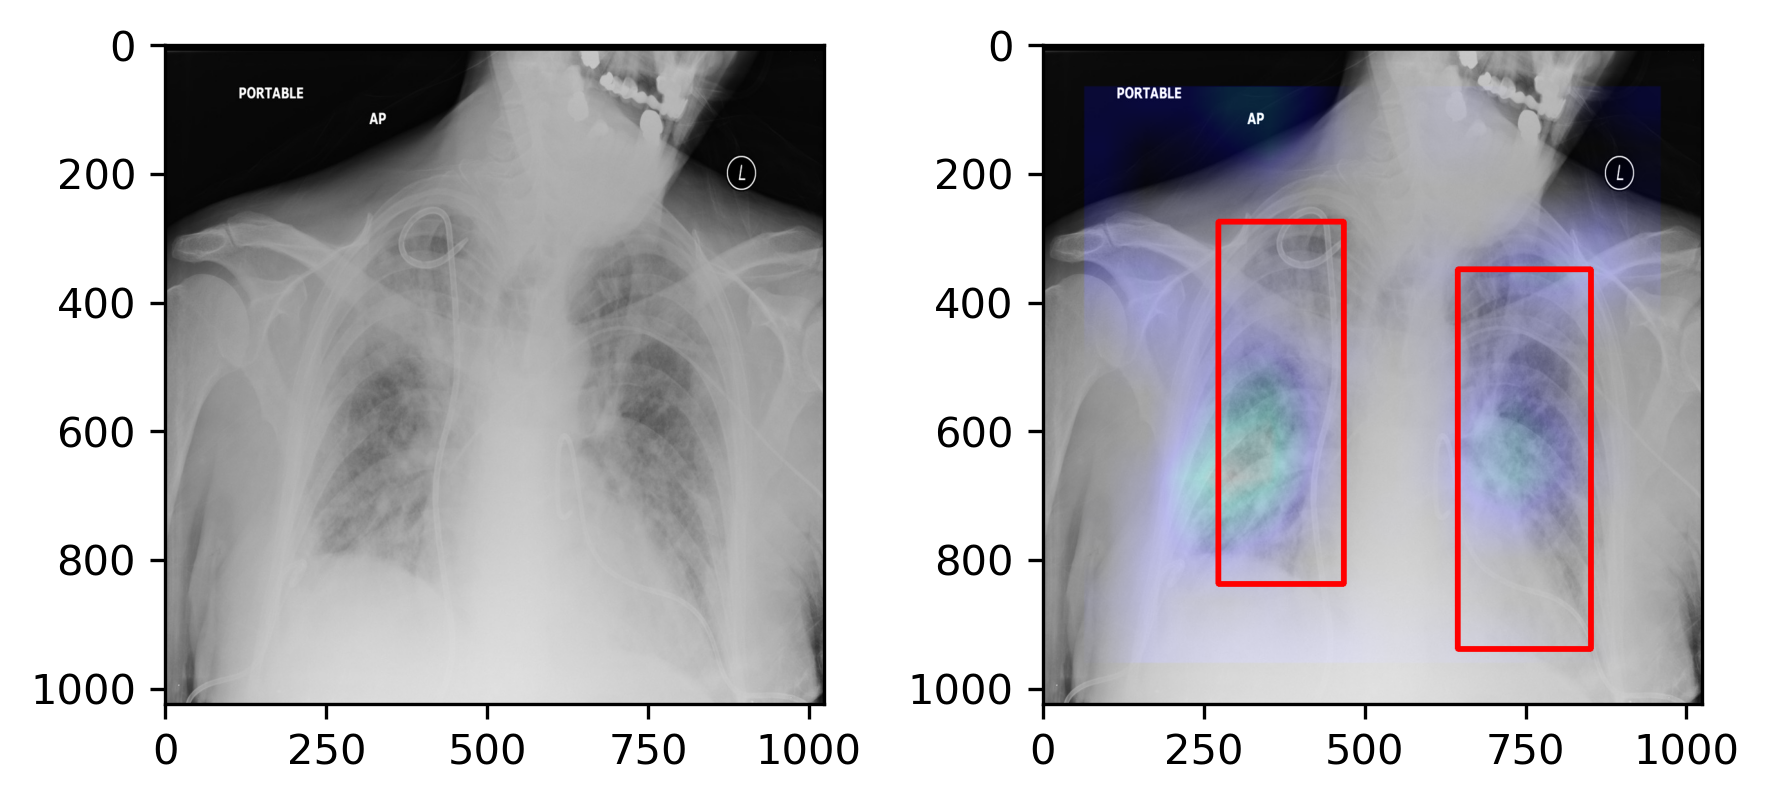

In [15]:
# Implementation adapted from https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
def show_gradcam(model, patient, target):
    model.eval()
    inputs = dataset[patient.patientId].unsqueeze(dim=0)
    
    outputs = model(inputs)
    
    pred = (outputs >= 0.0).int().item()

    outputs.backward()
    
    with torch.no_grad():
        # pull the gradients out of the model
        gradients = model.get_activations_gradient()

        # pool the gradients across the channels
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        # get the activations of the last convolutional layer
        activations = model.get_activations(inputs)
        # weight the channels by corresponding gradients
        for i in range(pooled_gradients.shape[0]):
            activations[:, i, :, :] *= pooled_gradients[i]

        # average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)
    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    img_path = ''.join([image_dir, '/', patient.patientId, '.dcm'])

    image = dicom.dcmread(img_path)
    
    print(['no-pneumonia', 'pneumonia'][target])
    print('Age', image.PatientAge)  
    print('Sex', image.PatientSex)
    print('Densnet predicted correctly?', (pred == target))

    heatmap_x = cv2.resize(heatmap.numpy(), (448, 448))
    heatmap_x = np.pad(heatmap_x, 32)
    heatmap_x = cv2.resize(heatmap_x, (image.pixel_array.shape[1], image.pixel_array.shape[0]))
    heatmap_x = np.uint8(255 * heatmap_x)
    heatmap_x = cv2.applyColorMap(heatmap_x, cv2.COLORMAP_HOT)
    
    image = cv2.cvtColor(image.pixel_array, cv2.COLOR_GRAY2RGB)
    image_x = cv2.addWeighted(image, 1.0, heatmap_x, .2, 1.0)
    # Draw bounding box
    if target == 1:
        for row in all_label_df[all_label_df.patientId==patient.patientId].iloc[:, 1:-1].values:
            x, y, w, h = np.int64(row)
            image_x = cv2.rectangle(image_x, (x, y), (x+w, y+h), (255, 0, 0), 7)

    fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=300)
    ax1.imshow(image)
    ax2.imshow(image_x)
    fig.tight_layout()
    plt.show()

target = 1

if target == 0:
    patient_ix = np.random.randint(0, neg_class_count)
elif target == 1:
    patient_ix = np.random.randint(0, pos_class_count)

patient = label_df[label_df.Target==target].iloc[patient_ix]

show_gradcam(model, patient, target)